In [1]:
import EEG_Decoder.eeg_decoder as eeg_decoder
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from utils import clean_behavior
%load_ext autoreload
%autoreload 2

In [ ]:
np.random.seed(2023)

In [2]:
experiment_name = 'DATA/Preprocessed'
data_dir = f'../../{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False, trim_timepoints=[-250, 1250])

In [3]:
exp.behavior_files = sorted(list(exp.data_dir.glob('*.csv')))
exp.eyetracking_files = sorted(list(exp.data_dir.glob('*eyetracking.mat'))) # 009 has no eye tracking, only EOG

In [4]:
time_window = 25
time_step = 25
trial_bin_size = 20
n_splits = 1000
group_dict = OrderedDict([('Set size 1',[11, 13]),('Set size 2',[21, 22, 23])])

wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [5]:
sub_nDots = {'SS1': [], 'SS2': []}
for isub in range(exp.nsub):
    print(isub)
    
    _, ydata = exp.load_eeg(isub)
    xdata, _ = exp.load_eyetracking(isub)
    
    # get info about nDots ranges
    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()
    
    behavior = pd.read_csv(exp.behavior_files[isub])

    behavior = clean_behavior(behavior, noArt_idx, isub)    
    assert len(behavior)==xdata.shape[0]
    
    # drop interruption trials for subs 4,5
    no_interruption_trials = (behavior.port_codes < 240).values
    behavior = behavior[no_interruption_trials].reset_index(drop=True)
    xdata = xdata[no_interruption_trials, :, :]
    
    sub_nDots['SS1'].append(behavior.query('total_nDots >= 24').query('SetSize==1').total_nDots.mean())
    sub_nDots['SS2'].append(behavior.query('total_nDots >= 24').query('SetSize==2').total_nDots.mean())
    
    # subset to match nDots range
    matched_dots_idx = behavior.query('total_nDots >= 24').index.values
    xdata = xdata[matched_dots_idx, :, :]
    ydata = ydata[matched_dots_idx]
    
    xdata,ydata = wrangl.group_labels(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):
        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test) 
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [6]:
interp = eeg_decoder.Interpreter(clfr, subtitle='1vs2')

Significant timepoints: [ 638  662  686  710  734  758  782  806  830  926  950  974  998 1022
 1046 1070 1094 1118 1142 1166 1190 1214]
Mean delay accuracy: 0.5339423067212039
Mean delay S.D.: 0.016975689024980947


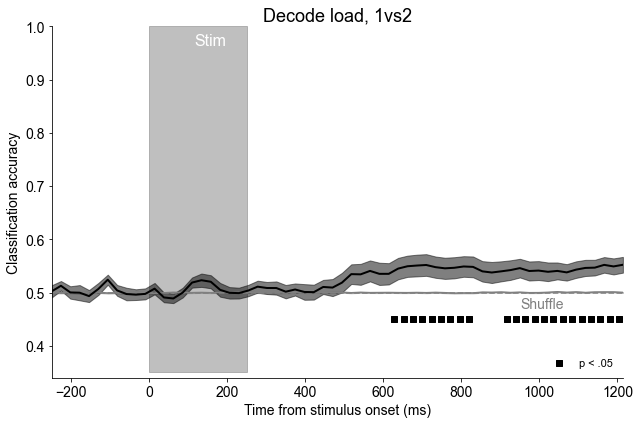

In [7]:
interp.plot_acc(significance_testing=True,savefig=False,ylim=[.34,1],chance_text_y=.23, title='Decode load, 1vs2')
plt.tight_layout()
plt.savefig('RawFigures/decode_load_fromEyes.svg')

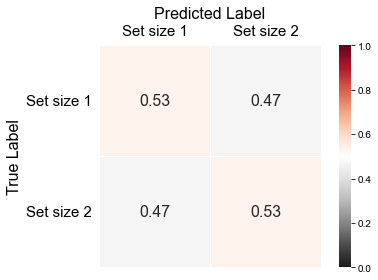

In [8]:
interp.plot_confusion_matrix()

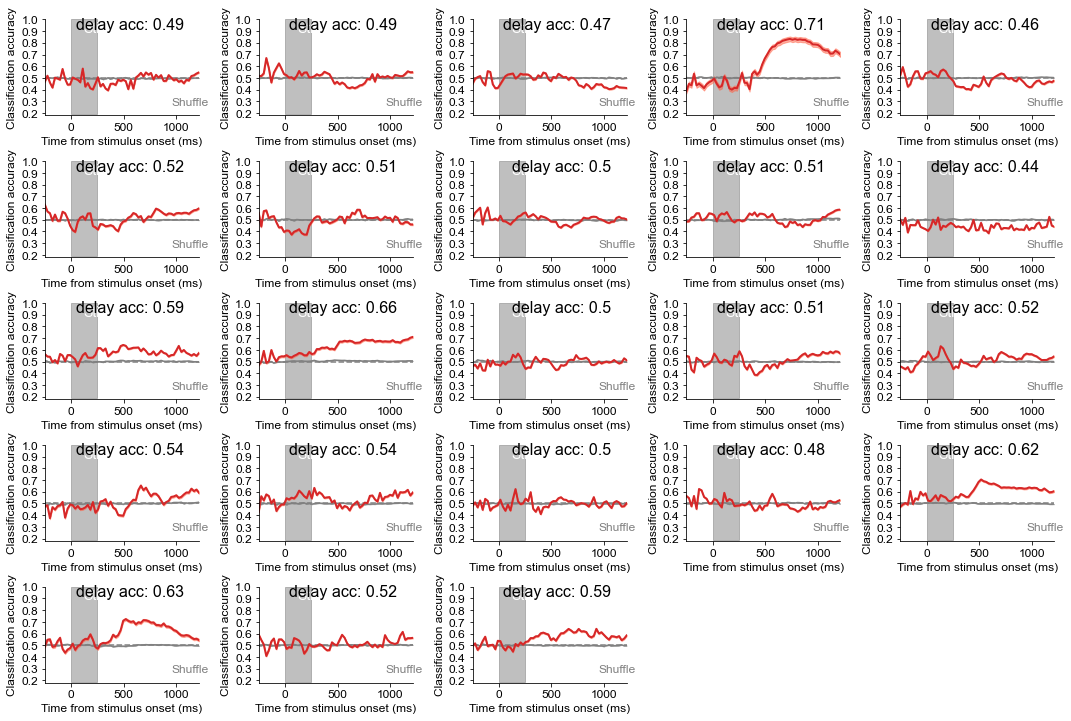

In [9]:
interp.plot_acc_by_subject(subplot_dims=(5,5))

In [10]:
sub_delay_accs = {}
for isub in range(exp.nsub):
    sub_delay_accs[isub] = interp.acc[isub][interp.t > 250].mean()

sub_delay_accs_df = pd.DataFrame.from_dict(sub_delay_accs, orient='index', columns=['acc'])
sub_delay_accs_df.query('acc > .6').to_csv('informative_eye_subs.csv')
sub_delay_accs_df.query('acc > .6')

,acc
3,0.710512
11,0.657915
19,0.624222
20,0.626207


### Drop informative eye subs (3,11,20,21)

In [11]:
bad_eyes = sub_delay_accs_df.query('acc > .6').index.values
clfr.acc = np.delete(clfr.acc, bad_eyes, axis=0)
clfr.acc_shuff = np.delete(clfr.acc_shuff, bad_eyes, axis=0)
clfr.conf_mat = np.delete(clfr.conf_mat, bad_eyes, axis=0)

Significant timepoints: []
Mean delay accuracy: 0.5085167033437251
Mean delay S.D.: 0.012316000559743006


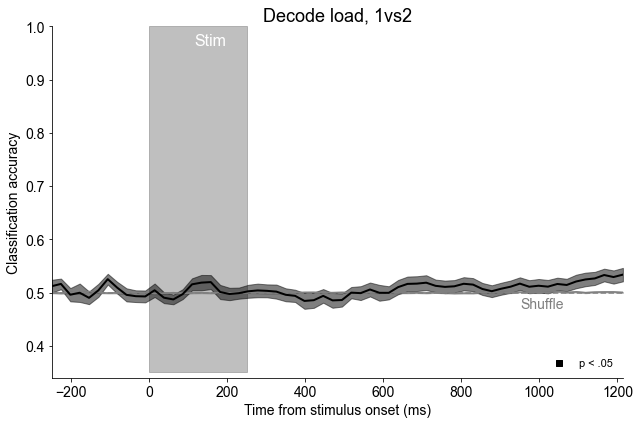

In [12]:
interp = eeg_decoder.Interpreter(clfr, subtitle='1vs2')
interp.plot_acc(significance_testing=True,savefig=False,ylim=[.34,1],chance_text_y=.23, title='Decode load, 1vs2')
plt.tight_layout()
plt.savefig('RawFigures/decode_load_fromEyes_noInformativeEyes.svg')

## Checking distribution of the mean number of dots across the two set sizes, after filtering

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

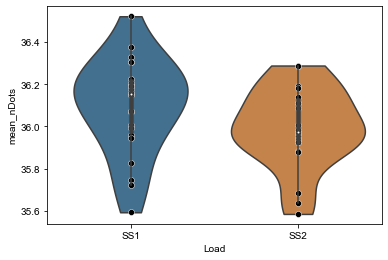

In [14]:
nDots_df = pd.DataFrame(sub_nDots)
melted_nDots = pd.melt(nDots_df, value_vars=['SS1', 'SS2'], var_name='Load', value_name='mean_nDots')

_ = sns.violinplot(x='Load', y='mean_nDots', data=melted_nDots, cut=0, saturation=.5)
_ = sns.scatterplot(x='Load', y='mean_nDots', data=melted_nDots, color='k')
_ = plt.xlim(-.5, 1.5)